In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import scorecardpy as sc
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Load

In [4]:
# Load datasets
data_loc = "data/"

samples = pd.read_csv(data_loc + 'samples.csv')
hold_out = pd.read_csv(data_loc + 'hold_out.csv')

In [5]:
samples.head()

,ID,application_date,generic_score,generic_score2,generic_score3,generic_score4,income_trend_score,indebtedness_score,loan_amount,loan_term,aggregator_group,age,region,social_accounts,social_score,job_sector,associate_flag,mortgage_flag,num_searches,num_accounts_closed,num_transactions,num_pi_records,num_months_pi_recorded,num_defaults,num_months_since_last_default,num_settled_good,num_settled_good_l6m,num_delinquents,num_of_revolving_accounts,outcome
0,44486,2021-06,1119,582,723,1.44,1.17,2,2600,48,Best Loans Warehouse,47,Scotland,1,29,3.0,1,0,-2,2,73.0,0,0,0,0,9,6,0,0,0
1,24045,2021-07,1012,561,1282,-1.30,0.61,-2,3000,24,Best Loans Warehouse,27,East of England,6,91,5.0,0,0,-2,0,NaN,0,0,0,0,5,2,0,0,0
2,48529,2020-12,927,615,367,-1.19,0.16,6,3000,60,Best Loans Warehouse,32,South West,0,10,8.0,0,0,-2,0,35.0,0,0,0,0,4,0,0,0,0
3,50879,2020-08,900,938,542,1.16,0.01,2,2800,12,Loan Saving Expert,27,Yorkshire and The Humber,0,12,2.0,0,0,-2,0,60.0,0,0,1,72,9,1,1,1,0
4,41672,2020-09,951,713,1283,1.22,0.28,5,2000,24,Other,25,London,3,43,5.0,0,0,1,5,98.0,0,0,0,0,3,0,0,0,0


# Explore

In [6]:
samples.application_date.value_counts()

2020-08    843
2020-12    821
2020-01    805
2021-12    804
2020-06    803
2020-05    789
2021-07    788
2021-08    785
2021-05    784
2021-01    783
2020-10    774
2020-04    767
2021-10    764
2021-03    762
2020-11    755
2020-03    749
2020-07    743
2021-06    742
2021-11    737
2021-04    736
2020-02    720
2021-02    709
2020-09    697
2021-09    693
Name: application_date, dtype: int64

In [7]:
samples.describe()

,ID,generic_score,generic_score2,generic_score3,generic_score4,income_trend_score,indebtedness_score,loan_amount,loan_term,age,social_accounts,social_score,job_sector,associate_flag,mortgage_flag,num_searches,num_accounts_closed,num_transactions,num_pi_records,num_months_pi_recorded,num_defaults,num_months_since_last_default,num_settled_good,num_settled_good_l6m,num_delinquents,num_of_revolving_accounts,outcome
count,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,16856.000000,18353.000000,18353.000000,18353.000000,18353.000000,16442.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000,18353.000000
mean,35126.957446,895.977606,735.943442,895.011987,-0.006368,-0.007798,10.239797,7651.999782,43.218057,38.112788,3.379665,65.122977,4.036545,0.487931,0.369967,-1.240342,3.027352,49.649130,0.073939,2.860895,0.231679,7.351986,5.954394,1.877949,0.335313,1.681360,0.119762
std,12653.722827,188.421506,182.081405,396.009984,1.178505,0.990703,12.992998,5254.241859,16.062554,9.881282,2.119862,34.599234,2.588149,0.499868,0.482809,1.078614,2.035676,28.887918,0.329846,12.099967,0.652392,18.321960,3.016328,1.840771,0.811940,1.610886,0.324692
min,12951.000000,-998.000000,407.000000,-1576.000000,-1.880000,-5.000000,-3.000000,1500.000000,12.000000,21.000000,0.000000,10.000000,1.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,0.000000
25%,24180.000000,781.000000,594.000000,590.000000,-1.160000,-0.620000,2.000000,3500.000000,30.000000,30.000000,1.000000,36.000000,2.000000,0.000000,0.000000,-2.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,35203.000000,900.000000,699.000000,894.000000,-0.420000,0.010000,6.000000,6000.000000,48.000000,37.000000,4.000000,64.000000,3.000000,0.000000,0.000000,-2.000000,3.000000,49.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,0.000000
75%,46104.000000,1028.000000,842.000000,1203.000000,1.160000,0.690000,12.000000,10000.000000,60.000000,46.000000,5.000000,92.000000,6.000000,1.000000,1.000000,0.000000,5.000000,75.000000,0.000000,0.000000,0.000000,0.000000,9.000000,3.000000,0.000000,2.000000,0.000000
max,56885.000000,1458.000000,1600.000000,1922.000000,1.830000,2.970000,96.000000,25000.000000,60.000000,65.000000,6.000000,139.000000,9.000000,1.000000,1.000000,5.000000,9.000000,99.000000,5.000000,72.000000,9.000000,72.000000,9.000000,9.000000,9.000000,14.000000,1.000000


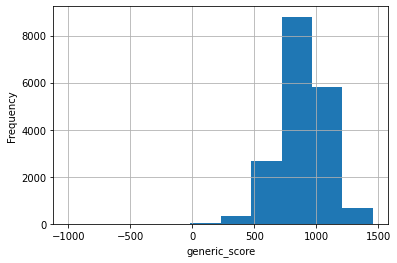

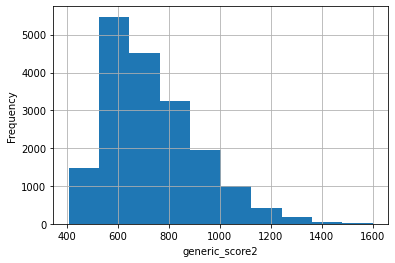

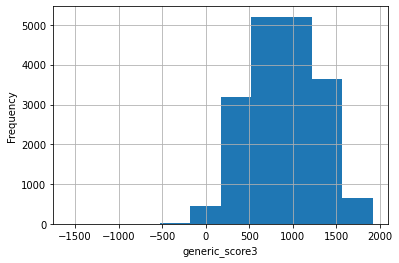

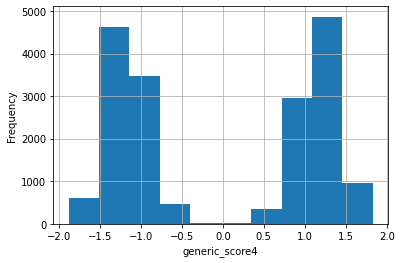

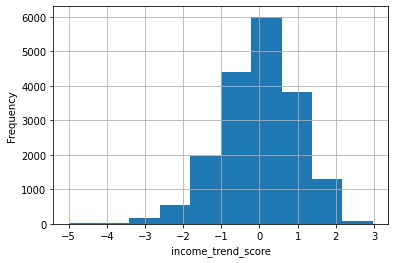

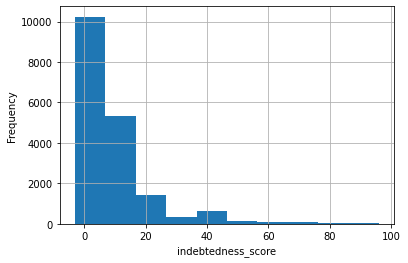

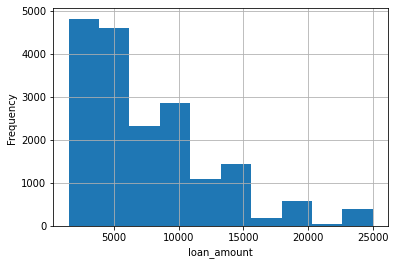

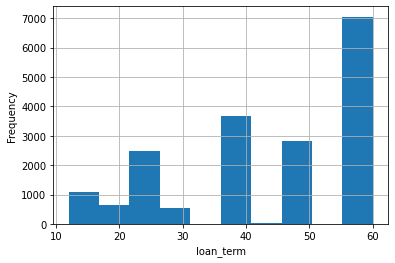

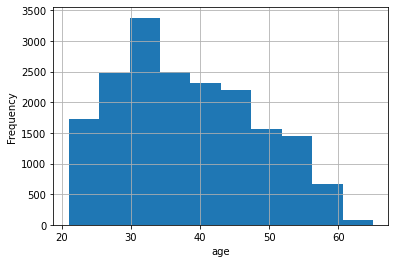

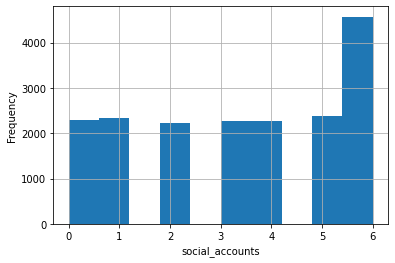

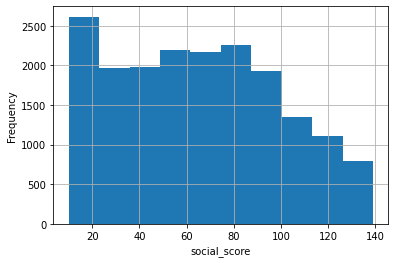

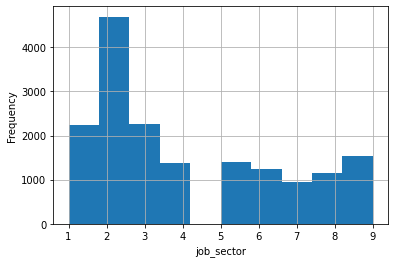

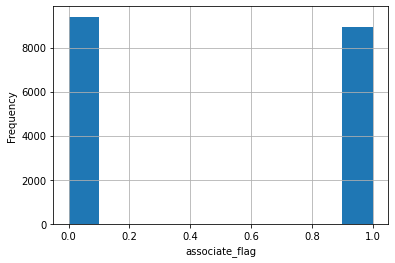

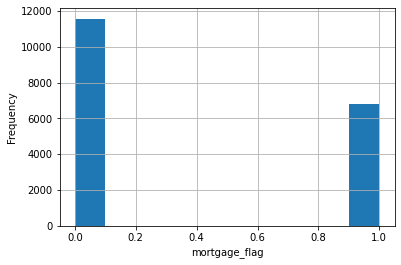

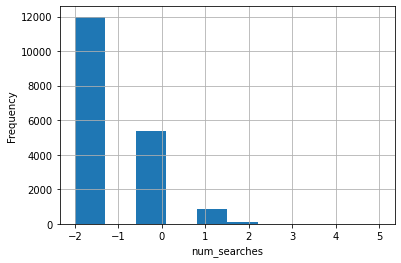

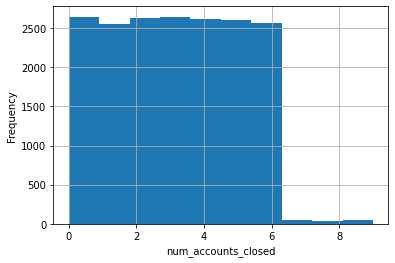

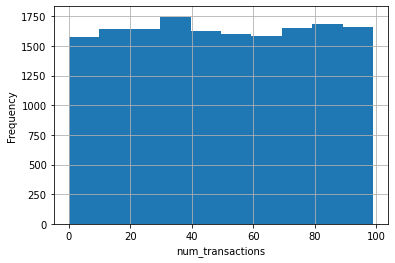

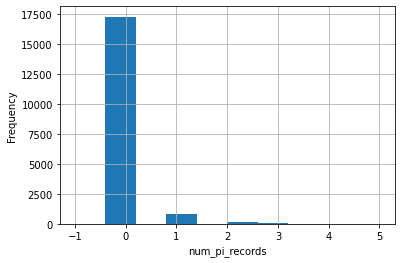

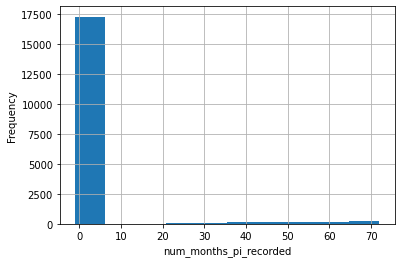

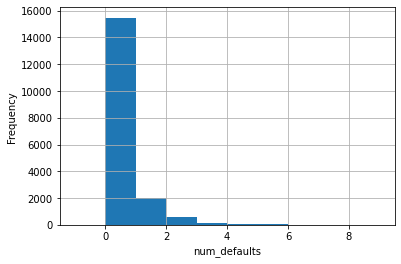

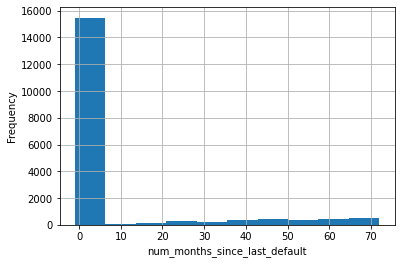

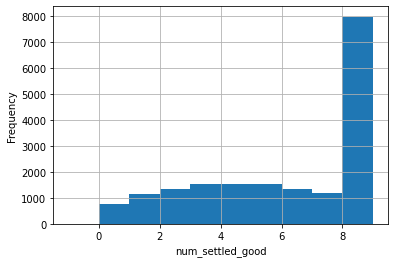

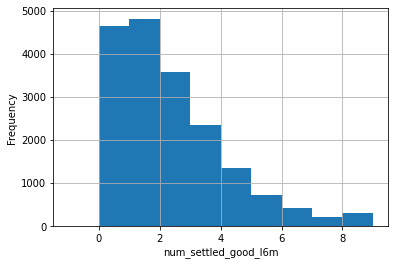

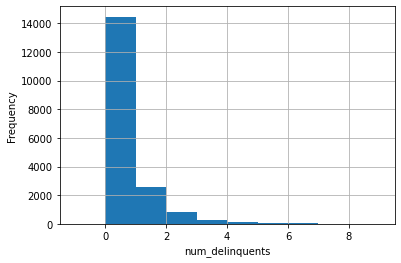

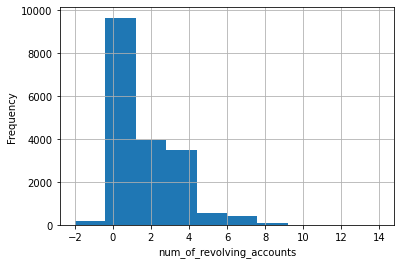

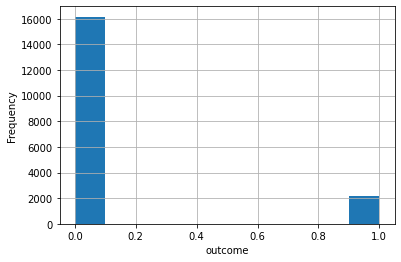

In [8]:
# Create histograms
for column in samples.columns:
    if column != 'ID':
        if samples[column].dtype != 'object':
            samples[column].hist()
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()

Some notes:  
generic_score: Some scores with default value of -998  
generic_score3: Very few scores below -400  
generic_score4: May need to take absolute value of this based on histogram distribution  
num_searches: Values range from -2 to 5  
num_pi_records: 80% of values are zero  
num_months_pi_recorded: One value of -1, 94% of values are zero  
num_defaults: One value is -1, 84% of values are zero  
num_months_since_last_default: One value of -1, 84% of values are zero  
num_of_revolving_accounts: 200 accounts have a default value of -2  

# Feature engineering

In [9]:
# Remove the single account where there are a lot of -1 values, this is likely a data error
samples = samples[samples['num_defaults'] != -1]

# Create a flag for generic_score missing
samples['generic_score'] = samples['generic_score'].replace(np.nan, -998)
samples['generic_score_missing'] = (samples['generic_score'] == -998).astype(int)

# Create a flag for generic_score3 less than -400
samples['generic_score3_category'] = np.where(samples['generic_score3'] < -400, 'low', 'normal')
samples['generic_score4_abs'] = samples['generic_score4'].abs()

# Create a flag for num_searches missing
samples['num_searches_missing'] = (samples['num_searches'] == -2).astype(int)
samples['num_searches'] = samples['num_searches'].replace(-2, np.nan)

# Create a flag for having a pi record
samples['has_pi_record'] = (samples['num_pi_records'] > 0).astype(int)
# Create a flag for having num_months_pi_recorded data
samples['num_months_pi_recorded_indicator'] = (samples['num_months_pi_recorded'] > 0).astype(int)

# Apply a log transformation to num_defaults to adjust for skewness
samples['num_defaults_log'] = np.log1p(samples['num_defaults'])

# Create bandings for num_months_since_last_default
samples['num_months_since_last_default_category'] = pd.cut(
    samples['num_months_since_last_default'],
    bins=[-1, 0, 12, np.inf],
    labels=['No Defaults', '<12 Months', '12+ Months']
)

# Create flag for num_of_revolving_accounts missing
samples['num_of_revolving_accounts_missing'] = (samples['num_of_revolving_accounts'] == -2).astype(int)
samples['num_of_revolving_accounts'] = samples['num_of_revolving_accounts'].replace(-2, np.nan)

In [10]:
# Handle missing values
num_imputer = SimpleImputer(strategy='median')
categoric_imputer = SimpleImputer(strategy='most_frequent')

num_features = samples.select_dtypes(include=['number']).columns
to_impute = [col for col in num_features if samples[col].isnull().sum() > 0]
samples[to_impute] = num_imputer.fit_transform(samples[to_impute])

samples['job_sector'] = categoric_imputer.fit_transform(samples[['job_sector']])

# Encoding categorical variables
label_encoders = {}
categorical_features = ['aggregator_group', 'region', 'job_sector', 'generic_score3_category', 'num_months_since_last_default_category']
for col in categorical_features:
    print(col)
    samples[col] = samples[col].astype(str)  # Convert to string to ensure uniform type
    le = LabelEncoder()
    samples[col] = le.fit_transform(samples[col])
    label_encoders[col] = le

aggregator_group
region
job_sector
generic_score3_category
num_months_since_last_default_category


# Prep data for modelling

In [11]:
# Define target and split data
X = samples.drop(columns=['ID', 'application_date', 'outcome'])
y = samples['outcome'] > 0  # Convert to binary classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=618)

In [12]:
# Function to iteratively remove high VIF features
def remove_high_vif_features(X, threshold=10, keep_feats=None):
    """
    Iteratively removes features with high VIF, keeping the specified features.
    
    Parameters:
    - X: DataFrame containing independent variables
    - threshold: VIF threshold for removal (default: 10)
    - keep_feats: List of features to always keep (default: None)

    Returns:
    - X: DataFrame after removing high VIF features
    - removed_features: List of removed features
    """
    if keep_feats is None:
        keep_feats = []
        
    removed_features = []
    
    while True:
        # Drop constant columns (prevents divide by zero in VIF)
        constant_cols = [col for col in X.columns if X[col].nunique() == 1]
        if constant_cols:
            X = X.drop(columns=constant_cols)
            removed_features.extend(constant_cols)
            print(f"Removed constant features: {constant_cols}")

        # Compute VIF
        vif_data = pd.DataFrame()
        vif_data['Feature'] = X.columns
        vif_data['VIF'] = [
            variance_inflation_factor(X.values, i) if X.shape[1] > 1 else 0  
            for i in range(X.shape[1])
        ]
        vif_data.sort_values(by='VIF', ascending=False, inplace=True, ignore_index=True)

        # Stop if all VIF values are below or equal to the threshold
        if vif_data['VIF'].max() <= threshold:
            break
        
        # Identify the feature with the highest VIF that is not in keep_feats
        for i, row in vif_data.iterrows():
            if row['Feature'] not in keep_feats and row['VIF'] > threshold:
                feature_to_remove = row['Feature']
                break
        else:
            break  # No more features to remove

        # Remove the feature and update the dataset
        X = X.drop(columns=[feature_to_remove])
        removed_features.append(feature_to_remove)
        print(f"Removed: {feature_to_remove} (VIF={row['VIF']:.2f})")
    
    return X, removed_features

In [13]:
# Identify features to keep
keep_feats = [
    'num_months_pi_recorded_indicator',
    'has_pi_record',
    'num_defaults_log'
]
keep_feats += [x for x in X_train.columns if 'score' in x]

# Apply iterative VIF removal
X_train, removed_features = remove_high_vif_features(X_train, threshold=10, keep_feats=keep_feats)
X_test = X_test.drop(columns=removed_features)

print(f"Final retained features: {X_train.columns.tolist()}")
print(f"Removed features: {removed_features}")

c:\Users\Faisal\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removed: num_defaults (VIF=41.04)


c:\Users\Faisal\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removed: num_months_since_last_default_category (VIF=18.97)


c:\Users\Faisal\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Removed: num_months_pi_recorded (VIF=10.87)
Final retained features: ['generic_score', 'generic_score2', 'generic_score3', 'generic_score4', 'income_trend_score', 'indebtedness_score', 'loan_amount', 'loan_term', 'aggregator_group', 'age', 'region', 'social_accounts', 'social_score', 'job_sector', 'associate_flag', 'mortgage_flag', 'num_searches', 'num_accounts_closed', 'num_transactions', 'num_pi_records', 'num_months_since_last_default', 'num_settled_good', 'num_settled_good_l6m', 'num_delinquents', 'num_of_revolving_accounts', 'generic_score_missing', 'generic_score3_category', 'generic_score4_abs', 'num_searches_missing', 'has_pi_record', 'num_months_pi_recorded_indicator', 'num_defaults_log', 'num_of_revolving_accounts_missing']
Removed features: ['num_defaults', 'num_months_since_last_default_category', 'num_months_pi_recorded']


c:\Users\Faisal\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [14]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelling

## Log Reg

In [15]:
# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

LogisticRegression()

In [16]:
# Feature importance from Logistic Regression
log_reg_coeffs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})
print(log_reg_coeffs.sort_values(by='Coefficient', ascending=False))

                              Feature  Coefficient
4                  income_trend_score     0.573128
8                    aggregator_group     0.210253
17                num_accounts_closed     0.195227
5                  indebtedness_score     0.128584
13                         job_sector     0.124929
7                           loan_term     0.106835
23                    num_delinquents     0.084800
11                    social_accounts     0.056861
32  num_of_revolving_accounts_missing     0.047039
16                       num_searches     0.045029
1                      generic_score2     0.035412
25              generic_score_missing     0.011785
10                             region    -0.010373
26            generic_score3_category    -0.011785
18                   num_transactions    -0.012776
3                      generic_score4    -0.022811
6                         loan_amount    -0.033105
19                     num_pi_records    -0.033842
30   num_months_pi_recorded_ind

In [17]:
# # Get p-values for logistic regression
# logit_sm = sm.Logit(y_train, sm.add_constant(X_train_scaled)).fit()
# print(logit_sm.summary())
# Where p>0.05, it may be worth removing these features stepwise as these are insignificant and adding noise.
# (Note: this is using statsmodel log_reg, regularisation different to sklearn, align these if using in build)

## LightGBM

In [18]:
# Train lgbm model
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
}
lgbm = lgb.train(params, lgb_train, valid_sets=[lgb_test])

[LightGBM] [Info] Number of positive: 1757, number of negative: 12924
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 14681, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119678 -> initscore=-1.995478
[LightGBM] [Info] Start training from score -1.995478


In [19]:
# Feature importance from LightGBM
lgbm_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm.feature_importance()})
print(lgbm_importance.sort_values(by='Importance', ascending=False))

                              Feature  Importance
18                   num_transactions         335
1                      generic_score2         224
2                      generic_score3         220
9                                 age         187
12                       social_score         174
17                num_accounts_closed         174
6                         loan_amount         155
0                       generic_score         145
3                      generic_score4         136
21                   num_settled_good         128
24          num_of_revolving_accounts         123
5                  indebtedness_score         120
13                         job_sector         111
4                  income_trend_score         104
8                    aggregator_group          95
10                             region          74
22               num_settled_good_l6m          65
20      num_months_since_last_default          55
15                      mortgage_flag          52


# Models to scorecards

## Prepare hold out set

In [20]:
# Create hold_out_modified to get same features as used for X_train
hold_out_mod = hold_out.copy()

hold_out_mod['generic_score_missing'] = (hold_out_mod['generic_score'] == -998).astype(int)
hold_out_mod['generic_score'] = hold_out_mod['generic_score'].replace(-998, np.nan)
hold_out_mod['generic_score3_category'] = np.where(hold_out_mod['generic_score3'] < -400, 'low', 'normal')
hold_out_mod['generic_score4_abs'] = hold_out_mod['generic_score4'].abs()
hold_out_mod['num_searches_missing'] = (hold_out_mod['num_searches'] == -2).astype(int)
hold_out_mod['num_searches'] = hold_out_mod['num_searches'].replace(-2, np.nan)
hold_out_mod['has_pi_record'] = (hold_out_mod['num_pi_records'] > 0).astype(int)
hold_out_mod['num_months_pi_recorded_indicator'] = (hold_out_mod['num_months_pi_recorded'] > 0).astype(int)
hold_out_mod['num_defaults_log'] = np.log1p(hold_out_mod['num_defaults'])
hold_out_mod['num_months_since_last_default_category'] = pd.cut(
    hold_out_mod['num_months_since_last_default'],
    bins=[-1, 0, 12, np.inf],
    labels=['No Defaults', '<12 Months', '12+ Months']
)
hold_out_mod['num_of_revolving_accounts_missing'] = (hold_out_mod['num_of_revolving_accounts'] == -2).astype(int)
hold_out_mod['num_of_revolving_accounts'] = hold_out_mod['num_of_revolving_accounts'].replace(-2, np.nan)

c:\Users\Faisal\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
# Handle missing values
hold_out_mod[to_impute] = num_imputer.transform(hold_out_mod[to_impute])
hold_out_mod['job_sector'] = categoric_imputer.transform(hold_out_mod[['job_sector']])

In [22]:
# Try except used here, but label encoders should be present for all features - this is a possible issue with this code, revisit.
for col in categorical_features:
    print(col)
    hold_out_mod[col] = hold_out_mod[col].astype(str)
    le = label_encoders[col]
    try:
        hold_out_mod[col] = le.transform(hold_out_mod[col])
    except:
        print("\t(new fit)")
        hold_out_mod[col] = le.fit_transform(hold_out_mod[col])

aggregator_group
region
job_sector
generic_score3_category
num_months_since_last_default_category
	(new fit)


In [23]:
# Only keep columns used in training
hold_out_mod = hold_out_mod[X_train.columns]

In [24]:
hold_out_mod.columns

Index(['generic_score', 'generic_score2', 'generic_score3', 'generic_score4',
       'income_trend_score', 'indebtedness_score', 'loan_amount', 'loan_term',
       'aggregator_group', 'age', 'region', 'social_accounts', 'social_score',
       'job_sector', 'associate_flag', 'mortgage_flag', 'num_searches',
       'num_accounts_closed', 'num_transactions', 'num_pi_records',
       'num_months_since_last_default', 'num_settled_good',
       'num_settled_good_l6m', 'num_delinquents', 'num_of_revolving_accounts',
       'generic_score_missing', 'generic_score3_category',
       'generic_score4_abs', 'num_searches_missing', 'has_pi_record',
       'num_months_pi_recorded_indicator', 'num_defaults_log',
       'num_of_revolving_accounts_missing'],
      dtype='object')

## Log Reg

In [25]:
# Convert logistic regression to scorecard
bins = sc.woebin(samples, y='outcome', method='tree')
# logit_model = sc.scorecard(bins, model=log_reg, xcolumns=X_train.columns, points0=500, pdo=100)
X_woe = sc.woebin_ply(X[hold_out_mod.columns], bins)
logit_model = sc.scorecard(bins, model=log_reg, xcolumns=hold_out_mod.columns, points0=500, pdo=100)

[INFO] creating woe binning ...


c:\Users\Faisal\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:43: UserWarning: There are 1 date/time type columns are removed from input dataset. 
 (ColumnNames: application_date)
  warnings.warn("There are {} date/time type columns are removed from input dataset. \n (ColumnNames: {})".format(len(datetime_cols), ', '.join(datetime_cols)))


Binning on 18352 rows and 38 columns in 00:00:19
[INFO] converting into woe values ...


## LightGBM

In [26]:
# Predict scores
X_train['lgbm_score'] = lgbm.predict(X_train)
X_test['lgbm_score'] = lgbm.predict(X_test)
hold_out_mod['lgbm_score'] = lgbm.predict(hold_out_mod)
# Note: Booster version of LGBM used here rather than Classifier as we are doing binary classification, so 'predict' used gives probabilities of class 1, rather than using 'predict_proba' with the Classifier version that would give probabilities of each class

In [27]:
# Convert to log-odds
hold_out_mod['log_odds'] = np.log(hold_out_mod['lgbm_score'] / (1 - hold_out_mod['lgbm_score']))

# Convert to scorecard
pdo = 100
points0 = 500
factor = pdo / np.log(2)
hold_out_mod['lgbm_credit_score'] = points0 - factor * hold_out_mod['log_odds']
hold_out_mod['lgbm_credit_score'] = [int(x) for x in hold_out_mod['lgbm_credit_score']]

# Threshold and Decision

In [28]:
# Define acceptance threshold
accept_threshold = 750
hold_out_mod['decision'] = hold_out_mod['lgbm_credit_score'].apply(lambda x: 'Accept' if x >= accept_threshold else 'Reject')

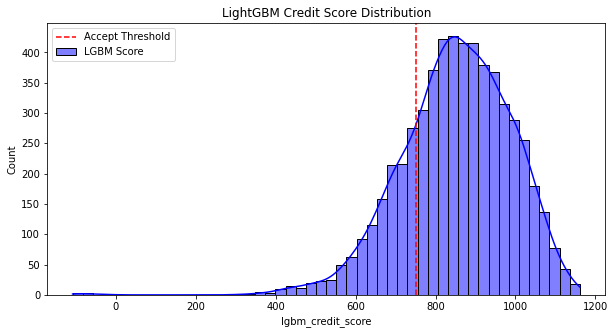

In [29]:
# Plot score distributions
plt.figure(figsize=(10, 5))
sns.histplot(hold_out_mod['lgbm_credit_score'], bins=50, kde=True, color='blue', label='LGBM Score')
plt.axvline(x=accept_threshold, color='red', linestyle='--', label='Accept Threshold')
plt.legend()
plt.title("LightGBM Credit Score Distribution")
plt.show()

## Write out

In [30]:
# Save predictions
hold_out_mod[['lgbm_score', 'lgbm_credit_score', 'decision']].to_csv(data_loc + 'hold_out_predictions.csv', index=False)

# Performance on Test Set

In [31]:
# Get test scores and decision
X_test['log_odds'] = np.log(X_test['lgbm_score'] / (1 - X_test['lgbm_score']))
X_test['lgbm_credit_score'] = points0 - factor * X_test['log_odds']
X_test['lgbm_credit_score'] = [int(x) for x in X_test['lgbm_credit_score']]
X_test['decision'] = X_test['lgbm_credit_score'].apply(lambda x: 'Accept' if x >= accept_threshold else 'Reject')

# Get outcomes of test set
X_test['outcome'] = samples['outcome']

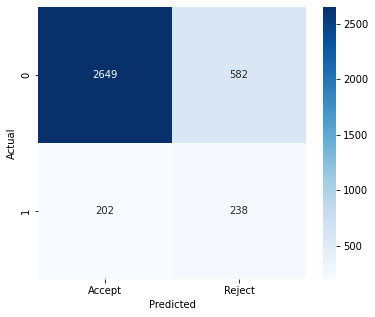

Accuracy: 0.7864
Precision: 0.2902
Recall: 0.5409
F1 Score: 0.3778


In [32]:
decision_map = {'Accept': 0, 'Reject': 1}
X_test['decision_numeric'] = X_test['decision'].map(decision_map)

# Generate the confusion matrix
conf_matrix = confusion_matrix(X_test['outcome'], X_test['decision_numeric'])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Accept', 'Reject'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(X_test['outcome'], X_test['decision_numeric'])
precision = precision_score(X_test['outcome'], X_test['decision_numeric'])
recall = recall_score(X_test['outcome'], X_test['decision_numeric'])
f1 = f1_score(X_test['outcome'], X_test['decision_numeric'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

## Further performance metrics

**Evaluation using AUC or Gini**  
AUC thresholds:  
 - 0.8–0.9  Good ability to classify default probability  
 - 0.7–0.8  Acceptable level of discrimination  
 - 0.6–0.7  Low ability to identify potential defaults  
  
Gini thresholds:  
 - 0.5-0.6  Good model  
 - 0.6-0.7  Very good model  
 - 0.7+     Excellent model  

The ROC Curve (Receiver Operating Characteristic Curve) plots the True Positive Rate (TPR) against the False Positive Rate (FPR).  
The AUC (Area Under the Curve) is the area under this curve, giving an intuitive view of model separability.

AUC: 0.76


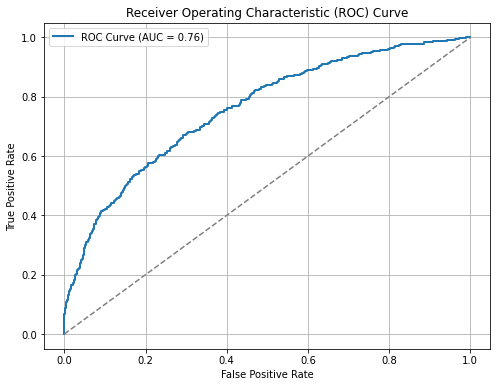

In [35]:
# Calculate ROC
fpr, tpr, _ = roc_curve(X_test['outcome'], X_test['lgbm_score'])
auc = roc_auc_score(X_test['outcome'], X_test['lgbm_score'])

print(f"AUC: {auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random model reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

The Lorenz Curve (Cumulative Gains Curve) shows the cumulative proportion of positive cases captured by the model.  
The Gini coefficient is the area between the Lorenz curve and the diagonal line.

Gini: 0.52


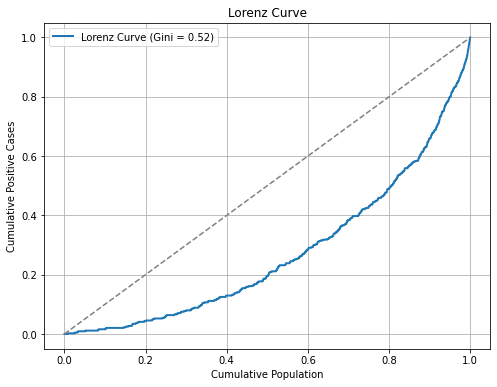

In [36]:
# Sort actual values by predicted score
sorted_indices = np.argsort(X_test['lgbm_score'])
sorted_actuals = X_test['outcome'].iloc[sorted_indices].values

# Calculate cumulative gains
cum_actuals = np.cumsum(sorted_actuals) / np.sum(sorted_actuals)
cum_population = np.arange(1, len(sorted_actuals) + 1) / len(sorted_actuals)

# Gini calculation
gini = 2 * auc - 1
print(f"Gini: {gini:.2f}")

# Plot Lorenz curve
plt.figure(figsize=(8, 6))
plt.plot(cum_population, cum_actuals, label=f'Lorenz Curve (Gini = {gini:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Line of equality
plt.xlabel('Cumulative Population')
plt.ylabel('Cumulative Positive Cases')
plt.title('Lorenz Curve')
plt.legend()
plt.grid()
plt.show()